In [1]:
import numpy
from matplotlib import pyplot
from scipy.constants import c

In [2]:
def window_function(u, u_0, sigma):
    return numpy.exp(-(u-u_0)**2.*sigma)

In [3]:
def averaged_window_function(u,u_offsets,sigma):
    offset_windows = numpy.array([window_function(u, u_i, sigma) for u_i in u_offsets])
    print(offset_windows.shape)
    
    averaged_window = numpy.mean(offset_windows, axis=0)
    print(averaged_window.shape)
    return averaged_window

In [4]:
def summed_window_function(u,u_offsets,sigma):
    offset_windows = numpy.array([window_function(u, u_i, sigma) for u_i in u_offsets])
    print(offset_windows.shape)
    
    summed_window = numpy.sum(offset_windows, axis=0)
    return summed_window

(4, 100)
(100,)
(4, 100)


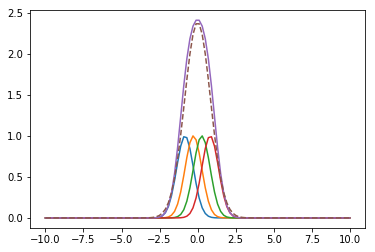

In [5]:
wavelength = 2.
x_coordinates = numpy.array([-1.5,-0.5,0.5,1.5])*1.1
u_offsets = x_coordinates/wavelength
width = (x_coordinates.max() - x_coordinates.min())/wavelength


u_coordinates = numpy.linspace(-10,10,100)

averaged_window = averaged_window_function(u_coordinates, u_offsets, width )
summed_window = summed_window_function(u_coordinates, u_offsets, width )



for offset in u_offsets:
    single = window_function(u_coordinates, offset, width)
    pyplot.plot(u_coordinates,single)

approximation = window_function(u_coordinates, 0, width*0.42)/0.42

#pyplot.plot(u_coordinates, averaged_window)
pyplot.plot(u_coordinates, summed_window)
pyplot.plot(u_coordinates, approximation, linestyle='--')

In [6]:
def beam_width(frequency, diameter= 4, epsilon = 1):
    return epsilon*c/(frequency*diameter)

In [7]:
class PointSourceSky:
    
    def __init__(self):
        self.flux_0 = None
        self.frequency_0 = None
        self.l_coordinate = None
        self.m_coordinate = None
        self.spectral_index = 0.8
        
        
    def add_source(self, flux, frequency_0 = 150e6, l_coordinate = 0, m_coordinate =0 , spectral_index=0.8):
        assert isinstance(flux, numpy.ndarray), "Please input a numpy array for flux"
        assert isinstance(frequency_0, numpy.ndarray), "Please input a numpy array for frequency"
        assert isinstance(l_coordinate, numpy.ndarray), "Please input a numpy array l coordinate"
        assert isinstance(m_coordinate, numpy.ndarray), "Please input a numpy array m coordinate"
        assert isinstance(spectral_index, numpy.ndarray), "Please input a numpy array spectral index"

        if self.flux_0 == None:
            self.flux_0 = flux
            self.frequency_0 = frequency_0
            self.l_coordinate = l_coordinate
            self.m_coordinate = m_coordinate
            self.spectral_index = spectral_index
        else:
            self.flux_0.append(flux)
            self.frequency_0.append(frequency_0)
            self.l_coordinate.append(l_coordinate)
            self.m_coordinate.append(m_coordinate)
            self.spectral_index.append(spectral_index)
        return
            
    

In [8]:
def visibility_model(u,v, frequency1, sources):
    visibilities = numpy.zeros(frequency1.shape, dtype=complex)
    nu_low = min(frequency1)
    for i in range(len(sources.flux_0)):
        source_l = sources.l_coordinate[i]
        source_m = sources.m_coordinate[i]
        
        beam_response = numpy.exp(-(sources.source_l**2. +  sources.m_coordinate[i]**2.)/beamwidth(frequency1))
        fourier_kernel= numpy.exp(-2*numpy.pi*1j*(source_l*u + source_m*v)*frequency1/nu_low)
        visibilities += sources.flux_0[i]*(frequency1/nu_low)**-0.8*beam_response*fourier_kernel
    return visibilities

def visibility_perturbation(u,v, frequency1, sources):
    perturbation = numpy.zeros(frequency1.shape, dtype=complex)
    nu_low = min(frequency1)
    for i in range(len(sources.flux_0)):
        source_l = sources.l_coordinate[i]
        source_m = sources.m_coordinate[i]
        beam_response = numpy.exp(-(sources.source_l**2. +  sources.m_coordinate[i]**2.)/beamwidth(frequency1))
        fourier_kernel= numpy.exp(-2*numpy.pi*1j*(source_l*u + source_m*v)*frequency1/nu_low)
        visibility = sources.flux_0[i]*(frequency1/nu_low)**-0.8*beam_response*fourier_kernel
        perturbation_phase = numpy.exp(2*numpy.pi*1j*sources.l_coordinate)
        perturbation += visibility
    
def beam_covariance(u ,nu1, nu2 ,S_0 = 100, source_l = 0, spectral_index = 0.8 ):
    nu_low = numpy.min(nu1)
    dx = 1.1
    beam_1 = beam_width(nu1)
    beam_2 = beam_width(nu2)
    
    Sigma = (beam_1**2.+ beam_2**2.)/(beam_1*beam_2)
    
    
    
    source_flux = S_0*(nu1*nu2/nu_low**2.)**-spectral_index
    beam_attenuation = numpy.exp(-source_l**2.*Sigma)
    
    VdV = numpy.exp(-2*numpy.pi*1j*u*source_l/nu_low*(nu1-nu2))*numpy.exp(4*numpy.pi*1j*source_l/beam_2)*\
    ((numpy.exp(-2*numpy.pi*1j*source_l/beam_2) - 1)**2./(numpy.exp(2*numpy.pi*1j*dx*nu2*source_l/c) - 1)**2.)
    
    dVV = numpy.exp(2*numpy.pi*1j*u*source_l/nu_low*(nu1-nu2))*numpy.exp(-4*numpy.pi*1j*source_l/beam_1)*\
    ((numpy.exp(2*numpy.pi*1j*source_l/beam_1) - 1)**2./(numpy.exp(2*numpy.pi*1j*dx*nu1*source_l/c) - 1)**2.)
    
    C = source_l*beam_attenuation*(VdV + dVV)
    
    return C

In [9]:
flux = numpy.array([100])
frequency_0 = numpy.array([150e6])
source_l = numpy.array([0])
source_m = numpy.array([0])
spectral_index = numpy.array([0.8])


sky_model = PointSourceSky()
sky_model.add_source(flux, frequency_0, source_l, source_m, spectral_index)

In [134]:
u_eor = 50
frequency_range = numpy.linspace(140, 160, 100)*1e6
ff1, ff2 = numpy.meshgrid(frequency_range, frequency_range)

analytic_covariance = beam_covariance(u_eor, ff1, ff2, source_l= 0.2)

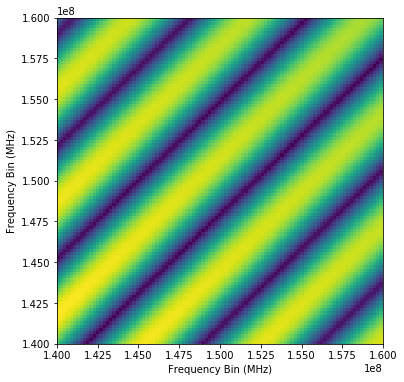

In [135]:
figure = pyplot.figure(figsize = (6,6))
covariance_plot = figure.add_subplot(111)
covariance_plot.pcolor(frequency_range, frequency_range,numpy.abs(analytic_covariance))
covariance_plot.set_xlabel('Frequency Bin (MHz)')
covariance_plot.set_ylabel('Frequency Bin (MHz)')


covariance_plot.set_aspect('equal')

## Compare with numerical covariance

In [136]:
import numpy
import powerbox
import time
import numexpr
from scipy import interpolate

from matplotlib import pyplot
from matplotlib.widgets import Slider
from scipy.constants import c as light_speed

import sys
sys.path.append('../../../redundant_calibration/code/SCAR')
from RadioTelescope import antenna_gain_creator
from RadioTelescope import baseline_converter
from RadioTelescope import xyz_position_creator
from SkyModel import flux_list_to_sky_image
from SkyModel import flux_distribution
from quick_simulation_visibility_covariance import lm_to_theta_phi
from quick_simulation_visibility_covariance import mwa_tile_beam
from quick_simulation_visibility_covariance import interactive_frequency_plotter
from quick_simulation_visibility_covariance import visibility_beam_covariance

In [137]:
# create array
sky_param = ['point', 200, 0.0, 0.]
noise_param = [False, 20e3, 40e3, 120]
beam_param = ['gaussian', 0.25, 0.25]
# telescope_param = ["hex", 14., 0, 0]
telescope_param = ["linear", 10, 5, 0]
sky_seed = 0

In [138]:
numerical_covariance = visibility_beam_covariance(telescope_param, frequency_range, sky_param)


Creating x- y- z-positions of a 5 element linear array

Converting xyz to uvw-coordinates

Number of antenna = 5
Total number of baselines = 10
Creating the sky



/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:167: RuntimeWarning: invalid value encountered in arcsin
  theta = numpy.arcsin(numpy.sqrt(ll ** 2. + mm ** 2.))
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:168: RuntimeWarning: divide by zero encountered in true_divide
  phi = numpy.arctan(mm / ll)
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:168: RuntimeWarning: invalid value encountered in true_divide
  phi = numpy.arctan(mm / ll)
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:168: RuntimeWarning: invalid value encountered in arctan
  phi = numpy.arctan(mm / ll)


Creating the idealised MWA beam



KeyboardInterrupt: 

In [ ]:
%matplotlib inline
figure = pyplot.figure(figsize = (12,6))
a_covariance_plot = figure.add_subplot(121)
a_covariance_plot.pcolor(frequency_range, frequency_range,numpy.abs(analytic_covariance))
a_covariance_plot.set_xlabel('Frequency Bin (MHz)')
a_covariance_plot.set_ylabel('Frequency Bin (MHz)')
a_covariance_plot.set_aspect('equal')


n_covariance_plot = figure.add_subplot(122)
n_covariance_plot.pcolor(frequency_range, frequency_range,numpy.abs(numerical_covariance))
n_covariance_plot.set_xlabel('Frequency Bin (MHz)')
n_covariance_plot.set_ylabel('Frequency Bin (MHz)')


n_covariance_plot.set_aspect('equal')
pyplot.show()

## Debugging the code

In [139]:
def visibility_extractor(baseline_table, sky_cube, antenna1_response, antenna2_response):
    apparent_sky = sky_cube*antenna1_response*numpy.conj(antenna2_response)
    padded_sky = numpy.pad(apparent_sky, 3*len(apparent_sky), mode = "constant")
    shifted_image = numpy.fft.ifftshift(padded_sky,  axes=(0, 1))
    visibility_grid, uv_coordinates = powerbox.dft.fft(shifted_image, L=2.,  axes=(0, 1))

    measured_visibilities = uv_list_to_baseline_measurements(baseline_table,visibility_grid, uv_coordinates)

    return measured_visibilities

In [140]:
def uv_list_to_baseline_measurements(baseline_table, visibility_grid, uv_grid):
    n_measurements = baseline_table.shape[0]

    #now we have the bin edges we can start binning our baseline table
    #Create an empty array to store our baseline measurements in
    visibility_data = visibility_grid

    real_component = interpolate.RegularGridInterpolator((uv_grid[0], uv_grid[1]), numpy.real(visibility_data))
    imag_component = interpolate.RegularGridInterpolator((uv_grid[0], uv_grid[1]), numpy.imag(visibility_data))

    visibilities = real_component(baseline_table[:, 2:4]) + \
                                           1j*imag_component(baseline_table[:, 2:4])

        #u_index = numpy.digitize(baseline_table[:, 2, frequency_index], bins=u_bin_edges)
        #v_index = numpy.digitize(baseline_table[:, 3, frequency_index], bins=v_bin_edges)

        #print("centers in u bins", u_bin_centers[u_index-1]
        #visibilities[:, frequency_index] = visibility_grid[u_index, v_index,frequency_index]

    return visibilities

In [141]:
# create array
sky_param = ['point', 200, 0.0, 0.]
noise_param = [False, 20e3, 40e3, 120]
beam_param = ['gaussian', 0.25, 0.25]
# telescope_param = ["hex", 14., 0, 0]
telescope_param = ["linear", 50, 5, 0]
sky_seed = 0

In [142]:
xyz_positions = xyz_position_creator(telescope_param)
gain_table = antenna_gain_creator(xyz_positions, frequency_range)
baseline_table = baseline_converter(xyz_positions, gain_table, frequency_range)



Creating x- y- z-positions of a 5 element linear array

Converting xyz to uvw-coordinates

Number of antenna = 5
Total number of baselines = 10


In [143]:
if sky_param[0] == 'random':
    all_flux, all_l, all_m = flux_distribution(['random', sky_seed])
elif sky_param[0] == 'point':
    all_flux, all_l, all_m = flux_distribution(['single', sky_param[1],
                                                    sky_param[2], sky_param[3]])
point_source_list = numpy.stack((all_flux, all_l, all_m), axis=1)


In [144]:
visibilities = numpy.zeros(frequency_range.shape[0], dtype=complex)
baseline_index = 0


sky_cube, l_coordinates, m_coordinates = flux_list_to_sky_image(point_source_list, baseline_selection)

/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:167: RuntimeWarning: invalid value encountered in arcsin
  theta = numpy.arcsin(numpy.sqrt(ll ** 2. + mm ** 2.))
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:168: RuntimeWarning: divide by zero encountered in true_divide
  phi = numpy.arctan(mm / ll)
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:168: RuntimeWarning: invalid value encountered in true_divide
  phi = numpy.arctan(mm / ll)
/home/ronniyjoseph/Sync/PhD/Projects/hybrid_calibration/code/tile_beam_perturbations/quick_simulation_visibility_covariance.py:168: RuntimeWarning: invalid value encountered in arctan
  phi = numpy.arctan(mm / ll)


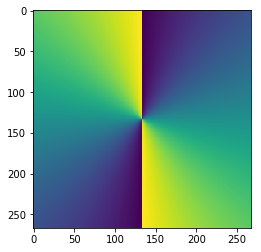

In [150]:
ll, mm, ff = numpy.meshgrid(l_coordinates, m_coordinates, frequency_range)
tt, pp, = lm_to_theta_phi(ll, mm)


In [152]:
ideal_beam = mwa_tile_beam(tt, pp, frequency_range)

[1.40000000e+08 1.40202020e+08 1.40404040e+08 1.40606061e+08
 1.40808081e+08 1.41010101e+08 1.41212121e+08 1.41414141e+08
 1.41616162e+08 1.41818182e+08 1.42020202e+08 1.42222222e+08
 1.42424242e+08 1.42626263e+08 1.42828283e+08 1.43030303e+08
 1.43232323e+08 1.43434343e+08 1.43636364e+08 1.43838384e+08
 1.44040404e+08 1.44242424e+08 1.44444444e+08 1.44646465e+08
 1.44848485e+08 1.45050505e+08 1.45252525e+08 1.45454545e+08
 1.45656566e+08 1.45858586e+08 1.46060606e+08 1.46262626e+08
 1.46464646e+08 1.46666667e+08 1.46868687e+08 1.47070707e+08
 1.47272727e+08 1.47474747e+08 1.47676768e+08 1.47878788e+08
 1.48080808e+08 1.48282828e+08 1.48484848e+08 1.48686869e+08
 1.48888889e+08 1.49090909e+08 1.49292929e+08 1.49494949e+08
 1.49696970e+08 1.49898990e+08 1.50101010e+08 1.50303030e+08
 1.50505051e+08 1.50707071e+08 1.50909091e+08 1.51111111e+08
 1.51313131e+08 1.51515152e+08 1.51717172e+08 1.51919192e+08
 1.52121212e+08 1.52323232e+08 1.52525253e+08 1.52727273e+08
 1.52929293e+08 1.531313

<IPython.core.display.Javascript object>


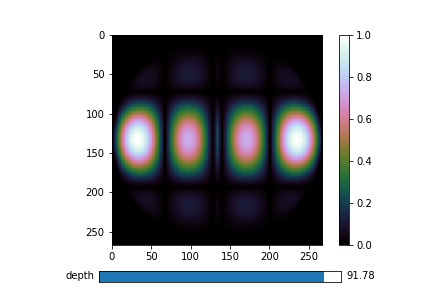

In [158]:
print(frequency_range)
%matplotlib notebook
interactive_frequency_plotter(numpy.abs(ideal_beam))

In [119]:
for frequency_index in range(len(frequency_range)):
    visibilities[frequency_index] = visibility_extractor(baseline_selection[:,:,frequency_index], 
                                                         sky_cube[:,:,frequency_index], 
                                                         ideal_beam[:,:,frequency_index], 
                                                         ideal_beam[:,:,frequency_index])

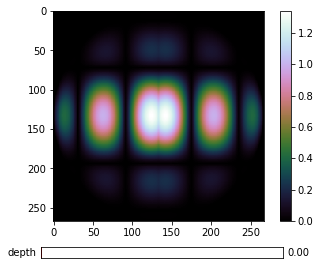

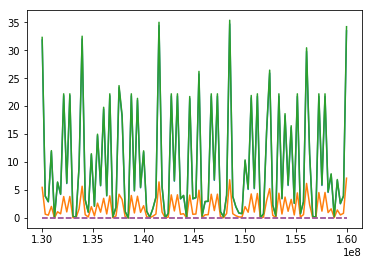

In [128]:
l_index = numpy.where(numpy.min(numpy.abs(l_coordinates - sky_param[2]) == numpy.abs(l_coordinates - sky_param[2]) ))[0]
m_index = numpy.where(numpy.min(numpy.abs(m_coordinates - sky_param[3]) == numpy.abs(m_coordinates - sky_param[3]) ))[0]


analytic = sky_param[1]*numpy.exp(-2.*numpy.pi*1j*(baseline_selection[0,2]*sky_param[2] 
                                                   + baseline_selection[0,3]**sky_param[3]))


pyplot.plot(frequency_range, numpy.real(visibilities))
pyplot.plot(frequency_range, numpy.imag(visibilities))
pyplot.plot(frequency_range, numpy.abs(visibilities))
pyplot.plot(frequency_range, numpy.real(beam_values), "--")
pyplot.plot(frequency_range, numpy.imag(beam_values), "--")
pyplot.show()

In [ ]:
%matplotlib inline
pyplot.plot(frequency_range,numpy.real(visibilities[0]))
pyplot.plot(frequency_range,numpy.imag(visibilities[0]))
pyplot.show()